In [385]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from co2data import *

# A Notch Digital Filter (6 marks, 3/2/1)

A notch filter is a filter that passes almost all frequencies with unit amplitude, except for a narrow
range of frequencies centered on the rejection frequency $f_0$ (at which frequency nothing is passed).

A simple notch digital filter has a z-transform

$$ W(z) = MF(z) F(z^*)^* = M \frac{z - q}{z - p} \frac{z - q^*}{z - p^*} $$

where $M$ is a normalization factor, $q = e^{-i 2 \pi f_0 / f_s}$, $p = (1 + \epsilon) q$, $f_s$ 
is the sampling rate ($f_s = 1 / \Delta$) and $\epsilon$ is a small positive number ($0 < \epsilon \ll 1$).

 1. What are the poles and zeros of this system? Where are they located with respect to the unit
    circle? Is this a stable system? Is this filter real? 
 2. Given $f_s = 12 \text{ cycles/year}$, $f_0 = 1 \text{ cycle/year}$, $M = 1.05$ and $\epsilon = 0.05$, plot the
    power spectrum $|W(f)|^2=W(f)W(f)^\ast$ (i.e., square of amplitude spectrum). Sample densely in $[-f_s/2, \ldots, f_s/2]$ (e.g. 1000 points), where $f_s/2$ is the Nyquist frequency.
 3. What is the full-width-half-max (FWHM) value $f_\text{fwhm}$ of this notch filter (based on the plot)? Which parameter(s) should you change to make the notches sharper, i.e., $f_\text{fwhm}$ smaller?

_Hint_: For Part 2, $W(f)$ is obtained by $W(z = e^{-i \omega \Delta}$). For Part 3, you don't have to
compute the FWHM value analytically (although it can be done); an inspection of the discrete array of $|W(f)|^2$
vector is sufficient. Note here $f_\text{fwhm}$ is in terms of frequency (1/year), not angular frequency.

__Part 1__

The poles of this system happen when $z-p = 0$ and $z-p^* = 0$. If we plug in the formula for $p$ and $q$, we have

$$
z = p = (1 + \epsilon)q 
\rightarrow z = (1 + \epsilon)e^{-i2\pi f_0/f_s} \\
$$

This means that in the complex plane, $r = (1 + \epsilon)$. Since $\epsilon > 0$ always, the pole lies outside of the unit circle. This is also true for the case when $z = p^*$ only that the circle runs counter clockwise. Next, the zeros of this system happens when $z-q = 0$ and $z-q^* = 0$, which gives

$$
z = q = e^{-i2\pi f_0/f_s}.
$$

That is, the zero lies on the unit circle in the complex plane. This is also true for $z-q^* = 0$.

Since the poles lie outside of unit circle, it is a realizable time series and thus stable and causal. However, because its causal then this filter is not pure real. 

__Part 2__

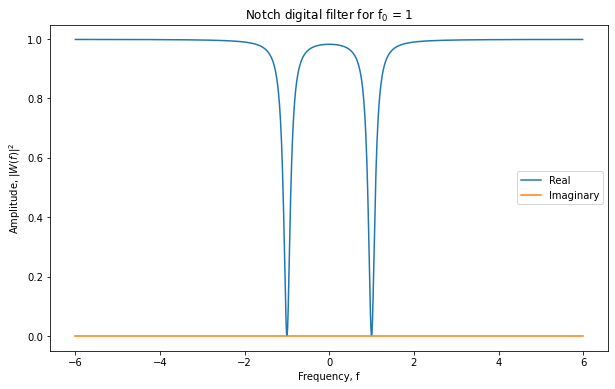

In [386]:
def d_filter(f, f0, fs, M, epsilon):
    g = (np.exp(-2j*np.pi*f/fs) - np.exp(-2j*np.pi*f0/fs))/(np.exp(-2j*np.pi*f/fs) - (1+epsilon)*np.exp(-2j*np.pi*f0/fs))
    h = (np.exp(-2j*np.pi*f/fs) - np.exp(2j*np.pi*f0/fs))/(np.exp(-2j*np.pi*f/fs) - (1+epsilon)*np.exp(2j*np.pi*f0/fs))
    W = M * g * h
    return W

fs = 12 # cycles/year
f0 = 1 # cycles/year
M = 1.05
eps = 0.05

f = np.arange(-fs/2, fs/2, 0.012)
A = d_filter(f, f0, fs, M, eps) * np.conj(d_filter(f, f0, fs, M, eps))

plt.figure(figsize=(10,6))
plt.plot(f, np.real(A), label="Real")
plt.plot(f, np.imag(A), label="Imaginary")
plt.xlabel("Frequency, f")
plt.ylabel("Amplitude, $|W(f)|^2$")
plt.title("Notch digital filter for f$_0$ = %s" % (f0))
plt.legend()

__Part 3__

To calculate the Full Width Half Maximum (FWHM) value, first we need to find the "maximum" value of the amplitude.  

In [387]:
index = np.array(np.where(np.round(A, 1) == 0.5))
index = np.delete(index, (2, 3))

FWHM = f[index[1]] - f[index[0]]
FWHM2 = f[index[3]] - f[index[2]]
FWHM3 = f[index[2]] - f[index[1]]


print("The FWHM value of the first peak is", FWHM, "/year")
print("The FWHM value of the second peak is", FWHM2, "/year")
print("The FWHM value in the middle is", FWHM3, "/year")

The FWHM value of the first peak is 0.1799999999999935 /year
The FWHM value of the second peak is 0.1799999999999935 /year
The FWHM value in the middle is 1.8239999999999341 /year


To make the notches sharper, we can change the $\epsilon$ parameter by making it smaller.

# Implementing the Notch Filter (6 marks, 2/2/1/1)

Notch filter introduced in section 1 can be written out fully as

$$ W(z) = \frac{N(z)}{D(z)} = \frac{a + bz + cz^2}{1 + Bz + Cz^2} $$

A filter of the form above can be implemented as two filters in succession: first the 'numerator filter'
`[a b c]` as a 3-term direct convolution, then the 'denominator filter' as the inverse filter of the 3-term
filter `[1 B C]` by feedback filtering.

 1. What are the values of a; b; c; B; C for the notch filter defined in Question 1.2?
 2. Write a function for a general rational digital filter with numerator and denominator
    coefficients N and D which produces the filtered time series $y$ for a given input $x$,
    `y = ratFilter(N,D,x)`. 
 3. Use `ratFilter` function to determine the impulse response of this notch filter (i.e., the output
    of this filter when the input is a discrete delta function). Define the impulse using $dt=1/f_s$ and $t=0$ to $t_{max}=100$ years (i.e. $1200$ samples). Plot the impulse response from $0$ to $6$ years. Speculate on how the impulse response would change if we halve the $f_\text{fwmh}$ value.
 4. Fourier transform the impulse response to obtain the frequency response $|W(f)|$
    of this notch filter. Plot it on top of the magnitude of the theoretical spectrum calculated based on the z-transform, with $f$ ranging from $0$ to $6$ cycles per year.

__Part 1__

If we start with our general equation of $W(z)$ from above, we have 

$$
\begin{align}
    W(z) &= M \frac{z-q}{z-p} \frac{z-q^*}{z-p^*} \\
    &= M\frac{|q|^2 - (q+q^*)z + z^2}{|p|^2 - (p+p^*)z + z^2} \\
\end{align}
$$

if we neglect M at the moment and sub in $p$ and the fact that $|q|^2 = 1$ then we have

$$
\begin{align}
    \frac{z-q}{z-p} \frac{z-q^*}{z-p^*} 
    &= \frac{1-(q+q^*)z + z^2}{(1+\epsilon)^2 - (1+\epsilon)(q+q^*)z + z^2} \\
    &= \frac{1-(q+q^*)z + z^2}{(1+\epsilon)^2 \left[ 1-\frac{(q+q^*)}{(1+\epsilon)}z + \frac{z^2}{(1+\epsilon)^2} \right] } \\
    &= \frac{(1+\epsilon)^{-2} [1-(q+q^*)z + z^2]}{\left[ 1-\frac{(q+q^*)}{(1+\epsilon)}z + \frac{z^2}{(1+\epsilon)^2} \right] } \\
    &= \frac{\frac{1}{(1+\epsilon)^2} - \frac{(q+q^*)}{(1+\epsilon)^2}z + \frac{z^2}{(1+\epsilon)^2}}{1-\frac{(q+q^*)}{(1+\epsilon)}z+\frac{z^2}{(1+\epsilon)^2}}
\end{align}
$$

Comparing this to the given equation above and plugging $M$ back in, we have 

$$
\begin{align}
    a &= \frac{M}{(1+\epsilon)^2} \\
    b &= -\frac{M(q+q^*)}{(1+\epsilon)^2} \\
    c &= \frac{M}{(1+\epsilon)^2} \\
    B &= -\frac{(q+q^*)}{(1+\epsilon)} \\
    C &= \frac{1}{(1+\epsilon)^2}
\end{align}
$$

this can be simplified further if we rewrite $q+q^* = 2 \cos(2\pi \frac{f_0}{f_s})$.

In [388]:
a = M / (1+eps)**2
b = -(2*M*np.cos(2*np.pi*f0/fs)) / (1+eps)**2
c = M / (1+eps)**2
B = -(2*np.cos(2*np.pi*f0/fs)) / (1+eps)
C = 1/(1+eps)**2

__Part 2__

Below we define our filter function. We follow the methodology defined in class, for an input signal $x$ the output signal $y$ is defined by 

$$
Y(z) = X(z)W(z) = X(z)\frac{N(z)}{D(z)} = \frac{F(z)}{D(z)}
$$

where $F(z) = X(z)N(z)$. To solve for $Y(z)$ we perform inverse filtering through the following formula 

$$
y_i = \frac{1}{d_0}\left[ f_i - \sum^M_{k=1} d_k y_{i-k}\right]
$$

where `M = len(D)`. 

In [389]:
def ratFilter(N, D, x):
    F = np.convolve(x, N) # F(z)
    # Apply inverse filtering process from lectures
    M = len(D)
    y = np.zeros(len(F) + 1 - len(D))
    for i in range(len(y)):
        total = 0 
        for k in range(1, M):
            total += D[k]*y[i-k] 
        y[i] = (1/D[0]) * (F[i] - total)
    return y

__Part 3__

Next we use the `ratFilter` function that we have created to find the impulse response of the notch filter by using a discrete delta function as our input signal. 

Text(0, 0.5, 'Response')

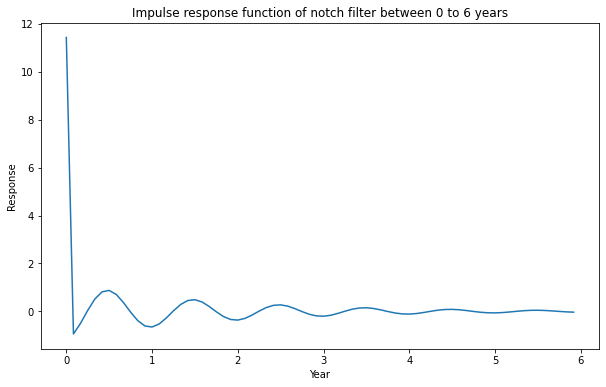

In [390]:
def Delta(t, dt):
    D = np.zeros(len(t))
    for i in range(len(t)):
        if t[i] == 0:
            D[i] = 1/dt
    return D

dt = 1/fs
t = np.arange(0, 100, dt)
N = [a,b,c]
D = [1,B,C]

output = ratFilter(N, D, Delta(t, dt))
t1 = int(6/dt) # 6 year mark

plt.figure(figsize=(10, 6))
plt.plot(t[:t1], output[:t1])
plt.title("Impulse response function of notch filter between 0 to 6 years")
plt.xlabel("Year")
plt.ylabel("Response")
#plt.ylim(-2, 2)

We speculate that with a change in $f_{\rm FWHM}$ value by halving it, then we essentially filter our Delta function in the frequency domain more precisely in the sense that there would be more left over frequency compared to when its unhalved. This would give more oscillations to the time domain of the impulse response function. 

__Part 4__

To get $|W(f)|$, we simply Fourier transform our `output` in the previous part. To find the theoretical spectrum we take the positive part of the function we obtained in part 2 of question 1 above.

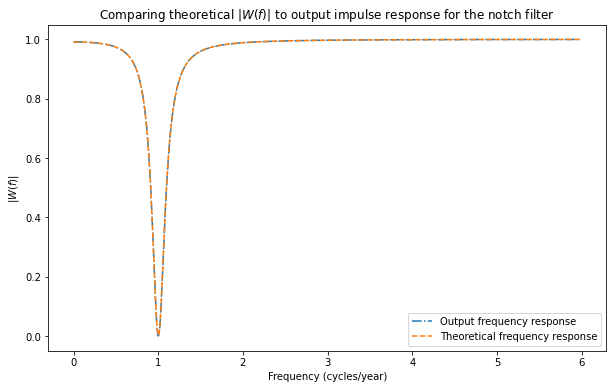

In [391]:
# FT output
fft_output = np.fft.fftshift(np.fft.fft(output) * dt)
output_freq = np.fft.fftshift(np.fft.fftfreq(len(output), dt))

# z-transform of notch filter from Q1
W = d_filter(f, f0, fs, M, eps)

plt.figure(figsize=(10,6))
plt.plot(output_freq[600:], np.real(fft_output[600:]), '-.', label="Output frequency response")
plt.plot(f[500:], np.real(W[500:]), '--', label="Theoretical frequency response")
plt.title("Comparing theoretical $|W(f)|$ to output impulse response for the notch filter")
plt.xlabel("Frequency (cycles/year)")
plt.ylabel("$|W(f)|$")
plt.legend()

# The Mauna Loa $CO_2$ Data (6 marks, 1/1/1/1/2)

The provided file `co2data.py` contains carbon dioxide values (in parts per million) measured
every month at the Mauna Loa Observatory in Hawaii, from January 1965 to December 2022.
They show clearly a rising trend in atmospheric $CO_2$. The trend is overlaid with a strong annual
oscillation. Your job is to remove the annual oscillation and display the trend more clearly. There
are two possible approaches: (a) you could apply your notch filter to the series to remove this
annual variation, or (b) you could Fourier transform it with `fft`, remove the annual variation by
setting the spectrum at appropriate frequencies to zero, and transform back to the time domain with
`ifft`.

Write code to accomplish the following:

 1. Before applying the filters, it is helpful to remove the trend of the signal using numpy
    function `polyfit`. Fit a straight line to your data and then detrend your data by removing the
    straight line. Plot both the original data and the detrended data.
 2. Apply your notch filter to the detrended data and add back the trend.
 3. FT the detrended data into the frequency domain, and plot both its amplitude and phase
    spectrum. Make another plot that zooms in at $f = [0, 3.5]$ cycles per year. Now set the
    Fourier spectrum corresponding to frequencies beyond $0.9$ cycles per year to zero (keeping in mind symmetry requirements), which
    effectively removes the annual oscillation. Transform the spectrum back to time domain and
    add back the trend.
 4. Now plot the original data, the notch-filtered data from Part 2 and f-domain filtered data
    from Part 3 on top of each other with different colors. Which method gives more satisfactory
    result? But can you think of any advantages/disadvantages in using either method?
 5. Now try redo Parts 2, 3, and 4 with the original data, not the detrended data. Of course you
    don't need to add back the trend after filtering any more. Display your results and comment
    on the importance of detrending before applying the filters.

__Part 1__

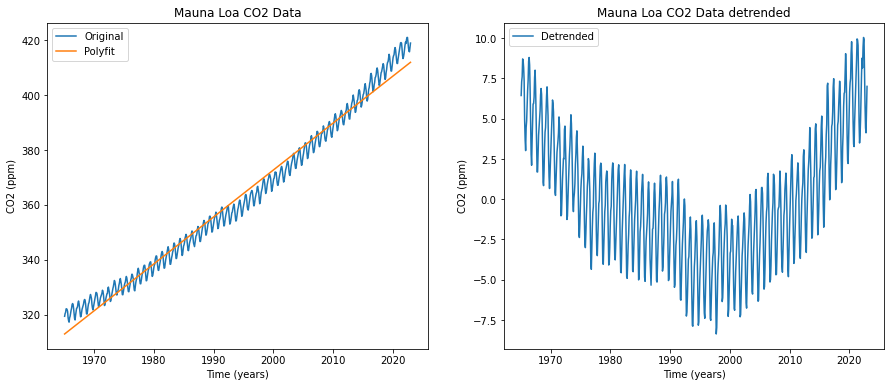

In [392]:
time = np.linspace(co2TimeRange[0], co2TimeRange[1], len(co2Data))

p = np.polyfit(time, co2Data, 1)
co2_fit = p[0]*time + p[1]
detrend_co2 = co2Data - co2_fit

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
ax[0].plot(time, co2Data, label="Original")
ax[0].plot(time, co2_fit, label="Polyfit")
ax[0].set_title("Mauna Loa CO2 Data")
ax[0].set_xlabel("Time (years)")
ax[0].set_ylabel("CO2 (ppm)")
ax[0].legend()
ax[1].plot(time, detrend_co2, label="Detrended")
ax[1].set_title("Mauna Loa CO2 Data detrended")
ax[1].set_xlabel("Time (years)")
ax[1].set_ylabel("CO2 (ppm)")
ax[1].legend()

__Part 2__

Below we apply our Notch filter that we found in Q2

Text(0.5, 1.0, 'Notch filtered data')

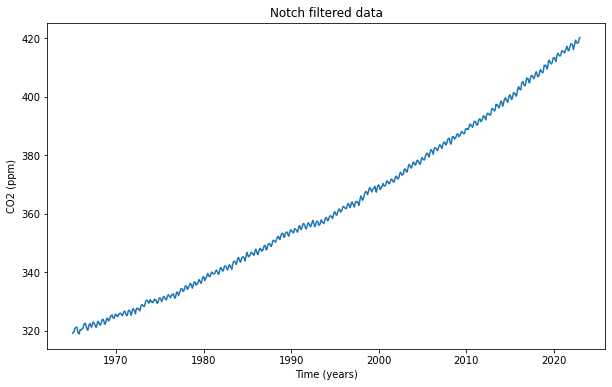

In [393]:
filtered_co2 = ratFilter(N, D, detrend_co2) + co2_fit

plt.figure(figsize=(10,6))
plt.plot(time, filtered_co2)
plt.xlabel("Time (years)")
plt.ylabel("CO2 (ppm)")
plt.title("Notch filtered data")

__Part 3__

Below we FFT our detrended data

Text(0, 0.5, 'Phase')

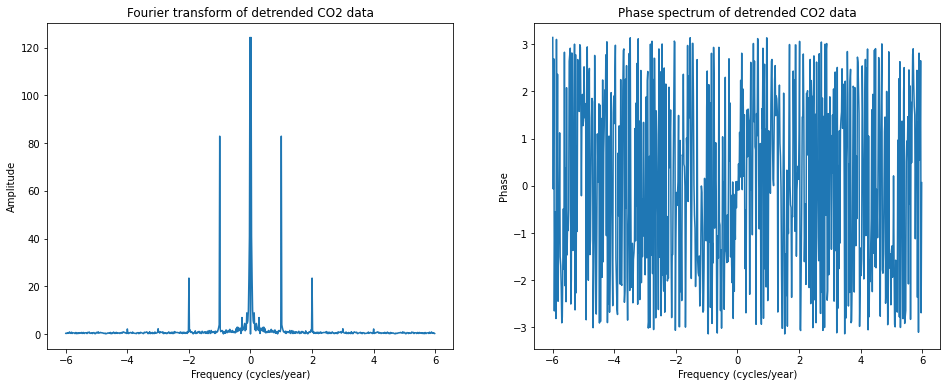

In [394]:
dt = time[1] - time[0]
fft_detrend_co2 = np.fft.fftshift(np.fft.fft(detrend_co2) * dt)
freq_detrend_co2 = np.fft.fftshift(np.fft.fftfreq(len(detrend_co2), dt))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].plot(freq_detrend_co2, np.abs(fft_detrend_co2))
ax[0].set_title("Fourier transform of detrended CO2 data")
ax[0].set_xlabel("Frequency (cycles/year)")
ax[0].set_ylabel("Amplitude")
ax[1].plot(freq_detrend_co2, np.angle(fft_detrend_co2))
ax[1].set_title("Phase spectrum of detrended CO2 data")
ax[1].set_xlabel("Frequency (cycles/year)")
ax[1].set_ylabel("Phase")

Next we make another plot that zooms into the [0, 3.5] frequencies

(-0.1, 3.5)

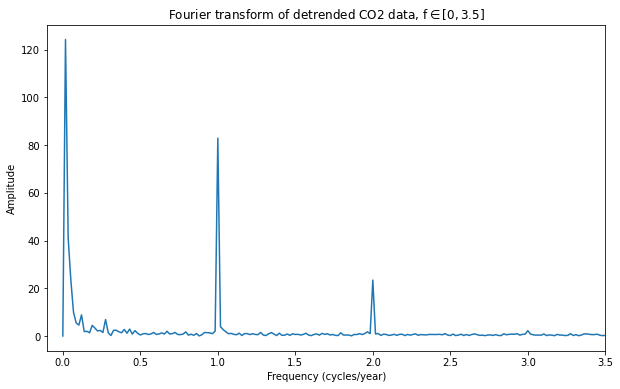

In [395]:
plt.figure(figsize=(10,6))
plt.plot(freq_detrend_co2[int(len(freq_detrend_co2)/2):], np.abs(fft_detrend_co2)[int(len(freq_detrend_co2)/2):])
plt.title("Fourier transform of detrended CO2 data, f$\in[0, 3.5]$")
plt.xlabel("Frequency (cycles/year)")
plt.ylabel("Amplitude")
plt.xlim(-0.1, 3.5)

Then we remove frequencies beyond $f = 0.9$ from our Fourier transform. We do this by defining a box function similar to the one we defined in the last lab.

(-1.0, 1.0)

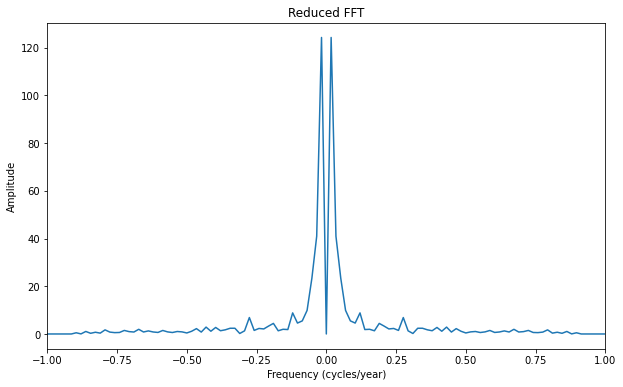

In [396]:
def Boxcar(t, T):
    b = np.zeros(len(t))
    for i in range(len(t)):
        if -T <= t[i] <= T: # keeping in mind symmetries
            b[i] = 1
    return b

rfft_detrend_co2 = fft_detrend_co2 * Boxcar(freq_detrend_co2, 0.9) # Cut off frequencies higher than 0.9

plt.figure(figsize=(10,6))
plt.plot(freq_detrend_co2, np.abs(rfft_detrend_co2))
plt.title("Reduced FFT")
plt.xlabel("Frequency (cycles/year)")
plt.ylabel("Amplitude")
plt.xlim(-1,1)

Finally, we transform this back to the time domain and add back the trend

In [397]:
new_co2_data = (np.fft.ifft(np.fft.ifftshift(rfft_detrend_co2)) / dt) + co2_fit

__Part 4__

From our plot below notice that the FT method gives a result that does not show apparent oscillations, i.e the most satisfying result. This is an advantage of FT versus the Notch filter. For example, if we are certain at removing a range of frequencies, then we can just remove it from the frequency domain like how we used our `Boxcar` for that. However, a disadvantage of this would be if we have certain frequencies we want to keep within that range then we will also delete it with the `Boxcar`. This is where the advantage of the Notch filter comes in. Since it specifically filters out the rejection frequency $f_0$ and you can specify the $f_{\rm FWHM}$ then you can control which specific frequency you do not want. Although, of course the disadvantage comes where you have a specific range of frequencies you want to delete then the Notch filter cannot do that and thus FT would be the better option. 

Since in our situation, we know that frequencies above $0.9$ are not part of what we want, using the FT method filters out everything beyond that and thus performs better when we `ifft` back to the time domain. Whereas Notch filter only filtered out $f=1$ and so the smaller peak in our Fourier spectrum did not get filtered out and as a result that is still imprinted in our signal when we `ifft` back into the time domain. 

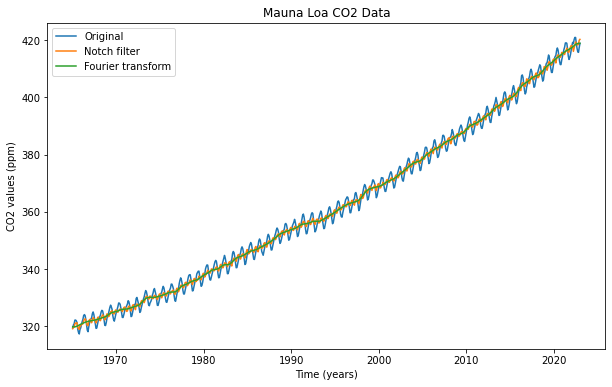

In [398]:
plt.figure(figsize=(10,6))
plt.plot(time, co2Data, label="Original") # Original Data
plt.plot(time, filtered_co2, label="Notch filter") # Notch filtered
plt.plot(time, np.abs(new_co2_data), label="Fourier transform") # Fourier transformed
plt.title("Mauna Loa CO2 Data")
plt.xlabel("Time (years)")
plt.ylabel("CO2 values (ppm)")
plt.legend()

__Part 5__

Below we repeat steps 2 - 4 with the original data

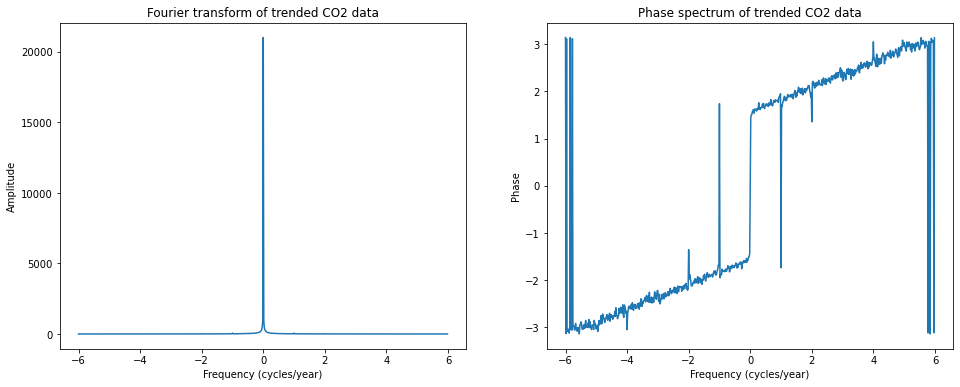

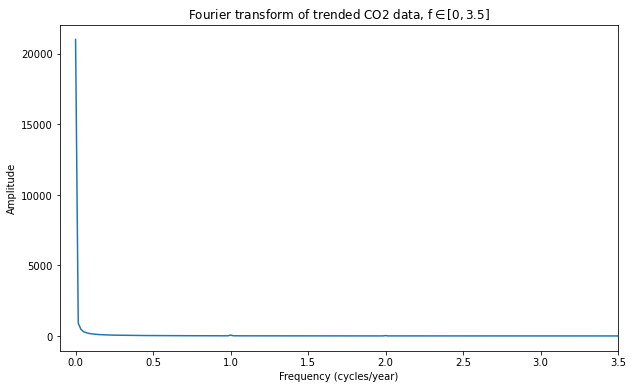

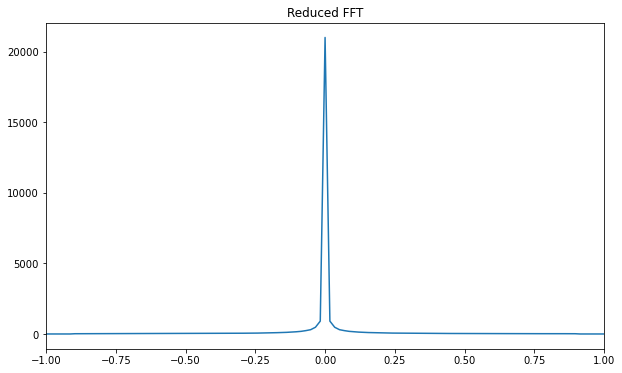

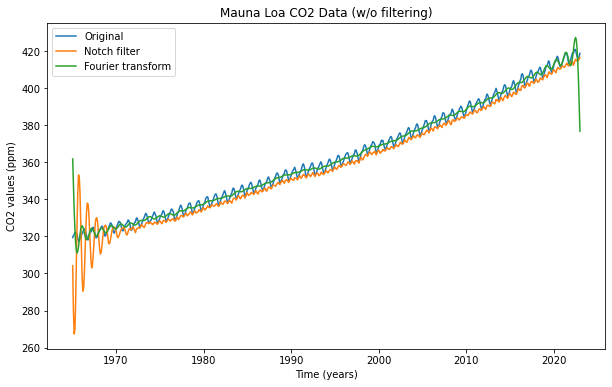

In [399]:
# Part 2
original_notched = ratFilter(N, D, co2Data)

# Part 3
original_fft = np.fft.fftshift(np.fft.fft(co2Data) * dt)
original_freq = np.fft.fftshift(np.fft.fftfreq(len(co2Data), dt))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].plot(original_freq, np.abs(original_fft))
ax[0].set_title("Fourier transform of trended CO2 data")
ax[0].set_xlabel("Frequency (cycles/year)")
ax[0].set_ylabel("Amplitude")
ax[1].plot(original_freq, np.angle(original_fft))
ax[1].set_title("Phase spectrum of trended CO2 data")
ax[1].set_xlabel("Frequency (cycles/year)")
ax[1].set_ylabel("Phase")

# Plotting for frequency in [0,3.5]
plt.figure(figsize=(10,6))
plt.plot(original_freq[int(len(original_freq)/2):], np.abs(original_fft)[int(len(original_freq)/2):])
plt.title("Fourier transform of trended CO2 data, f$\in[0, 3.5]$")
plt.xlabel("Frequency (cycles/year)")
plt.ylabel("Amplitude")
plt.xlim(-0.1, 3.5)

# We then cut off the higher frequencies
def Boxcar(t, T):
    b = np.zeros(len(t))
    for i in range(len(t)):
        if -T <= t[i] <= T: # keeping in mind symmetries
            b[i] = 1
    return b

original_rfft = original_fft * Boxcar(original_freq, 0.9) # Cut off frequencies higher than 0.9

plt.figure(figsize=(10,6))
plt.plot(original_freq, np.abs(original_rfft))
plt.title("Reduced FFT")
plt.xlim(-1,1)

new_original = (np.fft.ifft(np.fft.ifftshift(original_rfft)) / dt)

# Part 4
plt.figure(figsize=(10,6))
plt.plot(time, co2Data, label="Original") # Original Data
plt.plot(time, original_notched, label="Notch filter") # Notch filtered
plt.plot(time, np.abs(new_original), label="Fourier transform") # Fourier transformed
plt.title("Mauna Loa CO2 Data (w/o filtering)")
plt.xlabel("Time (years)")
plt.ylabel("CO2 values (ppm)")
plt.legend()

Notice above that our result with the original data becomes very funky when we do not detrend it. If we look at the FT plot for $f\in[0, 3.5]$, we see that the trend itself (having a frequency of zero), completely overrides the data that we are interested in that is close to $|f| = 0$. This means not only are we unable to accurately extract out the data that we are specifically interested in, we also input unwanted noise into our data and it becomes in accurate and distorted. This is exactly what we see in the ends of the notch filter and FT method in the time domain of the data. 